# Travel Trend (Intention to travel) of HKers between 2020 and 2022

## Step 1: Data Processing

#### Load all raw data

In [ ]:
import pandas as pd
import json
import ijson

f = open("posts_travel.json", "r", encoding="utf-8")
data = f.readlines()
data = list(map(json.loads, data)) 

#### Stanza by Stanford NLP group as NLP backbone. Since data source is in Traditional Chinese and stanza has better performance with Simplified Chinese, data source is translated to Simplified Chinese using OpenCC

In [ ]:
import stanza
import opencc

## Download NLP model (zh)
stanza.download('zh')

Initiate NLP pipeline

In [ ]:
nlp = stanza.Pipeline('zh', processors='tokenize,ner')

Initiate OpenCC converter

In [ ]:
converter = opencc.OpenCC('hk2s.json')

#### Translate data into Simplified Chinese using OpenCC, then apply stanza to extract NER associated with each sentence

In [ ]:
# To save processed result into result
result = []

def extract_country(nlp_result):
    ner = []
    try:
        for sent in nlp_result.sentences: 
            for token in sent.tokens:
                
                # Save only data rows having location NER 
                if "GPE" in token.ner:
                    ner.append((token.text, token.ner))
    except:
        pass
    
    return ner

for d in data:
    for m in d['msg']:
        try:
            msg_cleaned = "，".join(m['msg_cleaned'])
            
            # Translation with OpenCC
            msg_translated = converter.convert(msg_cleaned)
            
            # Apply stanza to tokenize each sentences
            nlp_result = nlp(msg_translated)
            
            # Extract result associated with location ner only
            ner = extract_country(nlp_result)
            
            # Check if there is any loaction ner in each row. If yes, save it to the result list
            if len(ner) > 0:
                post = dict(
                            post_id=d['post_id'],
                            resource=d['resource'],
                            title=d['title'],
                            msg=msg_cleaned,
                            author=m['author'],
                            date=m['pub_date']['$date'],
                            ner=ner
                        )
                result.append(post)
        except Exception as ex:
            # Prevent programme from stopping due to unforeseen error
            pass

Check how many results obtained in total

In [41]:
len(result)

257581

Print the first result to look at data structure and format

In [43]:
result[0]

{'post_id': 'lihkg_1114972',
 'resource': 'lihkg',
 'title': '有冇人暑假會喺中亞?',
 'msg': '哈薩克睇山水風景 一個禮拜包車係勉強夠嘅 但只可以去到喺almaty附近嘅景點',
 'author': '你老闆再慢啲?',
 'date': '2019-05-06T10:13:24Z',
 'ner': [['哈萨克', 'S-GPE'], ['喺almaty', 'S-GPE']]}

## Step 2: Upload to Google Cloud Storage for Vertex AI batch text prediction

In [ ]:
import jsonlines
from google.cloud import aiplatform, storage
from google.protobuf import json_format
import uuid

Create a bucket called travel_input_output to store all processed data and predicted data

In [ ]:
storage = storage.Client()
bucket = storage.bucket("travel_input_output")

#### Upload data in the right format for Vertex AI batch text prediction

In [ ]:
input_file_name = "total-prediction-input.jsonl"
BUCKET_URI = f"gs://travel_input_output"
input_file_data = []


for i, msg in enumerate(result):
    
    # Assign an uuid to map source data with predicted results
    msg['uuid'] = str(uuid.uuid1())
    instance_name = f"{msg['uuid']}.txt"
    instance_file_uri = f"{BUCKET_URI}/{instance_name}"

    # Store data in JSONL input file
    tmp_data = {"content": instance_file_uri, "mimeType": "text/plain"}
    input_file_data.append(tmp_data)

    # Create new instance file
    blob = bucket.blob(instance_name)
    blob.upload_from_string(msg['msg'])

input_str = "\n".join([str(d) for d in input_file_data])
file_blob = bucket.blob(f"{input_file_name}")
file_blob.upload_from_string(input_str)

#### Store all processed data

In [ ]:
with open('./posts_travel_processed.json' , 'w', encoding="utf8") as outfile:
        json.dump(result, outfile, ensure_ascii=False)

#### Run batch prediction in GCP web UI and wait for the results

## Step 3: Getting result

#### Use gsuil command to download all predidction data to prediction_results folder

In [4]:
import os 

BUCKET_OUTPUT = "gs://travel_input_output/total"
RESULTS_DIRECTORY = "prediction_results"
RESULTS_DIRECTORY_FULL = f"{RESULTS_DIRECTORY}/output"

# Create missing directories
os.makedirs(RESULTS_DIRECTORY, exist_ok=True)

# Get the Cloud Storage paths for each result
! gsutil -m cp -r $BUCKET_OUTPUT $RESULTS_DIRECTORY


Copying gs://travel_input_output/total/prediction-travel_0123_01-2022-05-11T13:20:17.581581Z/predictions_00001.jsonl...
Copying gs://travel_input_output/total/prediction-travel_0123_01-2022-05-11T13:20:17.581581Z/predictions_00002.jsonl...
Copying gs://travel_input_output/total/prediction-travel_0123_01-2022-05-11T13:20:17.581581Z/predictions_00003.jsonl...
Copying gs://travel_input_output/total/prediction-travel_0123_01-2022-05-11T13:20:17.581581Z/predictions_00006.jsonl...
Copying gs://travel_input_output/total/prediction-travel_0123_01-2022-05-11T13:20:17.581581Z/predictions_00010.jsonl...
Copying gs://travel_input_output/total/prediction-travel_0123_01-2022-05-11T13:20:17.581581Z/predictions_00005.jsonl...
Copying gs://travel_input_output/total/prediction-travel_0123_01-2022-05-11T13:20:17.581581Z/predictions_00007.jsonl...
Copying gs://travel_input_output/total/prediction-travel_0123_01-2022-05-11T13:20:17.581581Z/predictions_00008.jsonl...
Copying gs://travel_input_output/total/p

#### Find out all the file paths

In [ ]:
import glob

files_path = []
for dir in glob.glob("prediction_results/total/*"):
    files_path.extend(glob.glob("%s/*" % dir))


#### Consolide all data into one single array

In [ ]:
import json

prediction_data = []

for file in files_path:
    with open(file, "r") as f:
        for line in f:
            data.append(json.loads(line))

Check total number of prediction_data

In [41]:
len(prediction_data)

257581

Print the first 5 rows to look at data structure and format

In [15]:
prediction_data[:5]

[{'instance': {'content': 'gs://travel_input_output/e4b1f932-cef3-11ec-a6e0-42010a8a000b.txt',
   'mimeType': 'text/plain'},
  'prediction': {'ids': ['5092714109242179584',
    '7398557118455873536',
    '481028090814791680',
    '2786871100028485632'],
   'displayNames': ['1', '3', '0', '2'],
   'confidences': [0.8481917, 0.1133489, 0.028068874, 0.010390556]}},
 {'instance': {'content': 'gs://travel_input_output/2fada042-cefb-11ec-a6e0-42010a8a000b.txt',
   'mimeType': 'text/plain'},
  'prediction': {'ids': ['5092714109242179584',
    '7398557118455873536',
    '2786871100028485632',
    '481028090814791680'],
   'displayNames': ['1', '3', '2', '0'],
   'confidences': [0.9987587, 0.0010578779, 0.00010020654, 8.318211e-05]}},
 {'instance': {'content': 'gs://travel_input_output/577d837c-cef5-11ec-a6e0-42010a8a000b.txt',
   'mimeType': 'text/plain'},
  'prediction': {'ids': ['481028090814791680',
    '2786871100028485632',
    '7398557118455873536',
    '5092714109242179584'],
   'displa

#### Extract useful information from prediction_data

In [ ]:
prediction_processed = []

for d in prediction_data:
    # Extract the uuid in order to map processed data and predicted data
    filename = os.path.basename(d['instance']['content']).split(".")[0]
    
    obj = dict(
        uuid=filename,
        pred=d['prediction']['displayNames'][0], # Obtain the prediction result with highest condifence level
        confidence=d['prediction']['confidences'][0]
    )
    prediction_processed.append(obj)
    
    

Print the first 5 rows to look at data structure and format

In [23]:
prediction_processed[:5]

[{'uuid': 'e4b1f932-cef3-11ec-a6e0-42010a8a000b',
  'pred': '1',
  'confidence': 0.8481917},
 {'uuid': '2fada042-cefb-11ec-a6e0-42010a8a000b',
  'pred': '1',
  'confidence': 0.9987587},
 {'uuid': '577d837c-cef5-11ec-a6e0-42010a8a000b',
  'pred': '0',
  'confidence': 0.9332582},
 {'uuid': 'e0ff510a-cefc-11ec-a6e0-42010a8a000b',
  'pred': '1',
  'confidence': 0.9944382},
 {'uuid': 'f490f470-cef8-11ec-a6e0-42010a8a000b',
  'pred': '0',
  'confidence': 0.58264315}]

## Step 4: Data Analysis

#### Convert all previous data to dataframe

In [ ]:
import pandas as pd

prediction_processed_df = pd.DataFrame(prediction_processed)
posts_travel_df = pd.read_json('posts_travel_processed.json')

Print the first 5 rows of predicted result to look at data structure and format

In [25]:
prediction_processed_df.head(5)

,uuid,pred,confidence
0,e4b1f932-cef3-11ec-a6e0-42010a8a000b,1,0.848192
1,2fada042-cefb-11ec-a6e0-42010a8a000b,1,0.998759
2,577d837c-cef5-11ec-a6e0-42010a8a000b,0,0.933258
3,e0ff510a-cefc-11ec-a6e0-42010a8a000b,1,0.994438
4,f490f470-cef8-11ec-a6e0-42010a8a000b,0,0.582643


Print the first 5 rows of processed data to look at data structure and format

In [27]:
posts_travel_df.head(5)

,post_id,resource,title,msg,author,date,ner,uuid
0,lihkg_1114972,lihkg,有冇人暑假會喺中亞?,哈薩克睇山水風景 一個禮拜包車係勉強夠嘅 但只可以去到喺almaty附近嘅景點,你老闆再慢啲?,2019-05-06 10:13:24+00:00,"[[哈萨克, S-GPE], [喺almaty, S-GPE]]",d80bdc6e-ced2-11ec-a6e0-42010a8a000b
1,lihkg_1114972,lihkg,有冇人暑假會喺中亞?,如果有得揀，其實中亞五國都應該用BNO添，Visa兩邊難度都差唔多，弊咗屋企柒菇碌冇申請BNO,基輔七十一,2019-05-07 04:44:20+00:00,"[[中, S-GPE], [亚, S-GPE]]",d81ab072-ced2-11ec-a6e0-42010a8a000b
2,lihkg_1114972,lihkg,有冇人暑假會喺中亞?,係 佢會照批，反而塔吉克我仲未識填,基輔七十一,2019-05-09 16:30:57+00:00,"[[塔吉克, S-GPE]]",d825f1f8-ced2-11ec-a6e0-42010a8a000b
3,lihkg_1114972,lihkg,有冇人暑假會喺中亞?,中意山同大自然，下個月一個人去哈薩克5日，除左Charyn Canyon同Big Almat...,沒挽手才伶仃,2019-05-09 17:33:52+00:00,"[[哈萨克, S-GPE]]",d8320b50-ced2-11ec-a6e0-42010a8a000b
4,lihkg_1114972,lihkg,有冇人暑假會喺中亞?,啱啱去到吉爾吉斯啦，1800 tenge 由Almaty直送入Bishkek，有冇人喺度呀,基輔七十一,2019-05-19 12:11:33+00:00,"[[吉尔吉斯, S-GPE]]",d83d5be0-ced2-11ec-a6e0-42010a8a000b


#### Join both dataframes using uuid

In [ ]:
post_travel_joined = pd.merge(posts_travel_df, data_processed_df, on="uuid", 
                               how="left")

In [190]:
post_travel_joined.head(5)

,post_id,resource,title,msg,author,date,ner,uuid,pred,confidence
0,lihkg_1114972,lihkg,有冇人暑假會喺中亞?,哈薩克睇山水風景 一個禮拜包車係勉強夠嘅 但只可以去到喺almaty附近嘅景點,你老闆再慢啲?,2019-05-06 10:13:24+00:00,"[[哈萨克, S-GPE], [喺almaty, S-GPE]]",d80bdc6e-ced2-11ec-a6e0-42010a8a000b,0,0.557367
1,lihkg_1114972,lihkg,有冇人暑假會喺中亞?,如果有得揀，其實中亞五國都應該用BNO添，Visa兩邊難度都差唔多，弊咗屋企柒菇碌冇申請BNO,基輔七十一,2019-05-07 04:44:20+00:00,"[[中, S-GPE], [亚, S-GPE]]",d81ab072-ced2-11ec-a6e0-42010a8a000b,0,0.816546
2,lihkg_1114972,lihkg,有冇人暑假會喺中亞?,係 佢會照批，反而塔吉克我仲未識填,基輔七十一,2019-05-09 16:30:57+00:00,"[[塔吉克, S-GPE]]",d825f1f8-ced2-11ec-a6e0-42010a8a000b,1,0.584126
3,lihkg_1114972,lihkg,有冇人暑假會喺中亞?,中意山同大自然，下個月一個人去哈薩克5日，除左Charyn Canyon同Big Almat...,沒挽手才伶仃,2019-05-09 17:33:52+00:00,"[[哈萨克, S-GPE]]",d8320b50-ced2-11ec-a6e0-42010a8a000b,1,0.906053
4,lihkg_1114972,lihkg,有冇人暑假會喺中亞?,啱啱去到吉爾吉斯啦，1800 tenge 由Almaty直送入Bishkek，有冇人喺度呀,基輔七十一,2019-05-19 12:11:33+00:00,"[[吉尔吉斯, S-GPE]]",d83d5be0-ced2-11ec-a6e0-42010a8a000b,0,0.510132


Check the prediction distribution

<AxesSubplot:>

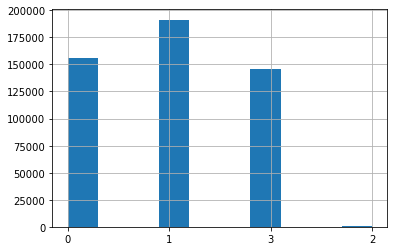

In [183]:
post_travel_joined['pred'].hist()

#### Data needs to be further processed in order to perform groupby function

In [ ]:
def ner_process(x):
    result = []
    for gpe in x:
        result.append(gpe[0])
    
    return result

# Remove S-GPE tagging in ner
post_travel_joined['ner_processed'] = post_travel_joined['ner'].apply(ner_process)
# Convert date string to be datetime
post_travel_joined['datetime'] = pd.to_datetime(post_travel_joined['date'])
# Extract year and month
post_travel_joined['year'] = post_travel_joined['datetime'].dt.year
post_travel_joined['month'] = post_travel_joined['datetime'].dt.month

# Split every ner result into individual rows
post_travel_joined = post_travel_joined.explode('ner_processed')

In [192]:
post_travel_joined.head(5)

,post_id,resource,title,msg,author,date,ner,uuid,pred,confidence,ner_processed,datetime,year,month
0,lihkg_1114972,lihkg,有冇人暑假會喺中亞?,哈薩克睇山水風景 一個禮拜包車係勉強夠嘅 但只可以去到喺almaty附近嘅景點,你老闆再慢啲?,2019-05-06 10:13:24+00:00,"[[哈萨克, S-GPE], [喺almaty, S-GPE]]",d80bdc6e-ced2-11ec-a6e0-42010a8a000b,0,0.557367,哈萨克,2019-05-06 10:13:24+00:00,2019,5
0,lihkg_1114972,lihkg,有冇人暑假會喺中亞?,哈薩克睇山水風景 一個禮拜包車係勉強夠嘅 但只可以去到喺almaty附近嘅景點,你老闆再慢啲?,2019-05-06 10:13:24+00:00,"[[哈萨克, S-GPE], [喺almaty, S-GPE]]",d80bdc6e-ced2-11ec-a6e0-42010a8a000b,0,0.557367,喺almaty,2019-05-06 10:13:24+00:00,2019,5
1,lihkg_1114972,lihkg,有冇人暑假會喺中亞?,如果有得揀，其實中亞五國都應該用BNO添，Visa兩邊難度都差唔多，弊咗屋企柒菇碌冇申請BNO,基輔七十一,2019-05-07 04:44:20+00:00,"[[中, S-GPE], [亚, S-GPE]]",d81ab072-ced2-11ec-a6e0-42010a8a000b,0,0.816546,中,2019-05-07 04:44:20+00:00,2019,5
1,lihkg_1114972,lihkg,有冇人暑假會喺中亞?,如果有得揀，其實中亞五國都應該用BNO添，Visa兩邊難度都差唔多，弊咗屋企柒菇碌冇申請BNO,基輔七十一,2019-05-07 04:44:20+00:00,"[[中, S-GPE], [亚, S-GPE]]",d81ab072-ced2-11ec-a6e0-42010a8a000b,0,0.816546,亚,2019-05-07 04:44:20+00:00,2019,5
2,lihkg_1114972,lihkg,有冇人暑假會喺中亞?,係 佢會照批，反而塔吉克我仲未識填,基輔七十一,2019-05-09 16:30:57+00:00,"[[塔吉克, S-GPE]]",d825f1f8-ced2-11ec-a6e0-42010a8a000b,1,0.584126,塔吉克,2019-05-09 16:30:57+00:00,2019,5


#### Split into two dataframes: to go and not to go

In [ ]:
post_travel_go = post_travel_joined[post_travel_joined['pred'] == "1"]
post_travel_not_go = post_travel_joined[post_travel_joined['pred'] == "2"]

In [179]:
post_travel_go.head(5)

,post_id,resource,title,msg,author,date,ner,uuid,pred,confidence,ner_processed,datetime,year,month
2,lihkg_1114972,lihkg,有冇人暑假會喺中亞?,係 佢會照批，反而塔吉克我仲未識填,基輔七十一,2019-05-09 16:30:57+00:00,"[[塔吉克, S-GPE]]",d825f1f8-ced2-11ec-a6e0-42010a8a000b,1,0.584126,塔吉克,2019-05-09 16:30:57+00:00,2019,5
3,lihkg_1114972,lihkg,有冇人暑假會喺中亞?,中意山同大自然，下個月一個人去哈薩克5日，除左Charyn Canyon同Big Almat...,沒挽手才伶仃,2019-05-09 17:33:52+00:00,"[[哈萨克, S-GPE]]",d8320b50-ced2-11ec-a6e0-42010a8a000b,1,0.906053,哈萨克,2019-05-09 17:33:52+00:00,2019,5
6,lihkg_1114972,lihkg,有冇人暑假會喺中亞?,問個膠膠地既問題 想知六月尾去哈薩克仲有冇得滑雪 定係個到已經close 左 諗住冇得滑都想...,你望下個天係咩色,2019-05-30 04:02:53+00:00,"[[哈萨克, S-GPE]]",d858e324-ced2-11ec-a6e0-42010a8a000b,1,0.665911,哈萨克,2019-05-30 04:02:53+00:00,2019,5
10,lihkg_1115430,lihkg,有無人番香港delay緊,我香港飛台灣,咪咪磨磨,2019-04-19 08:09:56+00:00,"[[香港, S-GPE], [台湾, S-GPE]]",d890d11c-ced2-11ec-a6e0-42010a8a000b,1,0.484573,香港,2019-04-19 08:09:56+00:00,2019,4
10,lihkg_1115430,lihkg,有無人番香港delay緊,我香港飛台灣,咪咪磨磨,2019-04-19 08:09:56+00:00,"[[香港, S-GPE], [台湾, S-GPE]]",d890d11c-ced2-11ec-a6e0-42010a8a000b,1,0.484573,台湾,2019-04-19 08:09:56+00:00,2019,4


In [180]:
post_travel_not_go.head(5)

,post_id,resource,title,msg,author,date,ner,uuid,pred,confidence,ner_processed,datetime,year,month
2999,babykingdom_normalthread_20450803,babykingdom,有冇JM 用過首爾TK traxxx,咁我又覺唔會，聽朋友講book日本韓國酒店係要早搞，唔同泰國，比我都係會咁上下時間比錢搞，假...,無話可說,2017-10-10 16:06:00+00:00,"[[日本, S-GPE], [韩国, S-GPE], [泰国, S-GPE]]",5b934ef0-ced3-11ec-a6e0-42010a8a000b,2,0.496360,日本,2017-10-10 16:06:00+00:00,2017,10
2999,babykingdom_normalthread_20450803,babykingdom,有冇JM 用過首爾TK traxxx,咁我又覺唔會，聽朋友講book日本韓國酒店係要早搞，唔同泰國，比我都係會咁上下時間比錢搞，假...,無話可說,2017-10-10 16:06:00+00:00,"[[日本, S-GPE], [韩国, S-GPE], [泰国, S-GPE]]",5b934ef0-ced3-11ec-a6e0-42010a8a000b,2,0.496360,韩国,2017-10-10 16:06:00+00:00,2017,10
2999,babykingdom_normalthread_20450803,babykingdom,有冇JM 用過首爾TK traxxx,咁我又覺唔會，聽朋友講book日本韓國酒店係要早搞，唔同泰國，比我都係會咁上下時間比錢搞，假...,無話可說,2017-10-10 16:06:00+00:00,"[[日本, S-GPE], [韩国, S-GPE], [泰国, S-GPE]]",5b934ef0-ced3-11ec-a6e0-42010a8a000b,2,0.496360,泰国,2017-10-10 16:06:00+00:00,2017,10
3039,babykingdom_normalthread_21401706,babykingdom,仲去吾去冲繩好,我五月頭去福岡 但同行有個一歲以下B，所以最後取消，酒店未比$，但機票個package 只退...,nick.hksar,2018-04-25 00:08:00+00:00,"[[福冈, S-GPE], [日本, S-GPE]]",5d46b7b4-ced3-11ec-a6e0-42010a8a000b,2,0.416914,福冈,2018-04-25 00:08:00+00:00,2018,4
3039,babykingdom_normalthread_21401706,babykingdom,仲去吾去冲繩好,我五月頭去福岡 但同行有個一歲以下B，所以最後取消，酒店未比$，但機票個package 只退...,nick.hksar,2018-04-25 00:08:00+00:00,"[[福冈, S-GPE], [日本, S-GPE]]",5d46b7b4-ced3-11ec-a6e0-42010a8a000b,2,0.416914,日本,2018-04-25 00:08:00+00:00,2018,4


#### Filter relative dates for both to go and not to go dataframes

In [ ]:
start_date = '2019-03-01'
end_date = '2022-03-31'
post_travel_go_filtered = post_travel_go[(post_travel_go['datetime'] >= start_date) & (post_travel_go['datetime'] <= end_date)]
post_travel_not_go_filterd = post_travel_not_go[(post_travel_not_go['datetime'] >= start_date) & (post_travel_not_go['datetime'] <= end_date)]


#### Aggregate to go result with top 20 total count

In [176]:
post_travel_go_filtered.groupby(['ner_processed']).size() \
.reset_index(name='count').sort_values(['count'], ascending=False).head(20)

,ner_processed,count
1420,日本,4259
2485,香港,3683
248,东京,2131
936,大阪,1895
699,台湾,1275
2131,英国,1211
692,台北,1044
1691,泰国,892
2467,韩国,703
1958,福冈,583


#### Aggregate not to go result with top 20 total count

In [96]:
post_travel_not_go.groupby('ner_processed').size() \
.sort_values(ascending=False).reset_index(name='count').head(20)

,ner_processed,count
0,日本,107
1,大阪,69
2,香港,61
3,东京,52
4,台湾,41
5,台北,35
6,泰国,32
7,韩国,29
8,冲绳,20
9,日,16
